# Moroccan Darija Trigger Word Classification ed .2

# IMPORTS

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense,Conv1D,Flatten,MaxPool1D,Dropout
from keras.models import Sequential

import librosa #if not installed install with : !pip install librosa 

# Loading the data

In [2]:
TRAINPATH= r"C:\Users\ahmed\Desktop\trigerwords\data\train"

In [159]:
train_csv=pd.read_csv(r"C:\Users\ahmed\Desktop\trigerwords\train.csv")


In [160]:
train_csv.head()

,id,label
0,gudj6np7lx4ov5a9y3wq,1
1,mi2z51y4jb7thxuf8ldr,1
2,ziuab84tvf07snxjhyodp,0
3,ulcdyxnbz6jqh9wmk4pa,1
4,gj8rfxzae4vibtohk62n1,0


In [3]:
TESTPATH= r"C:\Users\ahmed\Desktop\trigerwords\data\test"

In [166]:
test_csv=pd.read_csv(r"C:\Users\ahmed\Desktop\trigerwords\test.csv")

In [167]:
test_csv.head()

,id
0,4s8mxnikbt0f61qu2ea5
1,wcr5syvak4mq0tozn6i3d
2,qt6vl4jushkf7g5webcym
3,i84wvt3sa7golhud9x1f
4,o6013rbhaz94tlqmg8nc


# Preprocessing and modeling the data

In [6]:
train_file_names = tf.io.gfile.listdir(str(TRAINPATH))
print(train_file_names)

['0mbsexwoja8u4n12v5ql.wav', '0p5dwnmxgabovt8u4hrf.wav', '0tjkrsnv1lfcub7hp5ex2.wav', '0y4whrmeixdalkz8s6bju.wav', '1t6w3k05q7j8clfmy9ug.wav', '2glnftjbpehdy7xi953a.wav', '2jgkywshetpr43xdabn7.wav', '32bixqwuv5anmtgzl8cj.wav', '3kp695hfniwozetu0aqrg.wav', '3xpvqgtyd9ucwmk6bof4.wav', '3zebh15sl6djpx4ri7g0u.wav', '41g2s8z3i7dkhfwtyoul0.wav', '43kjhxb2d9qpmatrv51e.wav', '46khm1wtnip8zeb7doj0.wav', '4eh591vt6x2surm08l3o.wav', '4nt1978i5lmdk36pz2yxh.wav', '4pg0yrcdhjvo73mtanxf.wav', '4q67nahyc3gm2xerd9su.wav', '4qktn8a5f0jcbev1irldx.wav', '5dqlz0onixs9phy2vwm1b.wav', '5e842oanxf379huk0g6c.wav', '5iaso8rzd7pfexyvuk1jn.wav', '5vnh0ky62o9d4sm8xbgzt.wav', '5wt2u8abqh3lds4k9ivj.wav', '64gqyv7n3ksmirj0lp9t1.wav', '67crbeaq5diwjmtvpzxs0.wav', '6fbgkadenil574two32h.wav', '6fu2bqt759is1yh38vo0.wav', '6zub4xg3ij7daqf91lwyc.wav', '71srdp82j6xick4ovl9z.wav', '7rni6fcob13metld9auv.wav', '7rvnxekopwi81b3c6fsd.wav', '7xbwc2u3o8fiyhgrzqsv1.wav', '7xyjhfudqg81bz2lot36k.wav', '83nitwe2cp5f1bjr07zs.wav', '85z

In [7]:
test_file_names = tf.io.gfile.listdir(str(TESTPATH))

In [21]:
#function to trun our wav type data to arrays using te library librosa
def audio_to_array(file , semipath ):
    x,_ = librosa.load(semipath +r"\\" +file, sr=3000)
    x=(x-min(x))/(max(x)-min(x))
    return x.astype(np.float16)

In [12]:
#for example 
audio_to_array("ulcdyxnbz6jqh9wmk4pa.wav" ,TRAINPATH)

array([0.505 , 0.506 , 0.504 , ..., 0.4028, 0.5474, 0.5605], dtype=float16)

In [23]:
train_csv['label'].isna().sum()

0

In [161]:
train_csv['id']

0       gudj6np7lx4ov5a9y3wq
1       mi2z51y4jb7thxuf8ldr
2      ziuab84tvf07snxjhyodp
3       ulcdyxnbz6jqh9wmk4pa
4      gj8rfxzae4vibtohk62n1
               ...          
139     pyjvr51h8lea7364w0io
140    nkpyoaxbzi4ftv62cd98g
141     97fic3rxubmq0np82dzs
142     fznl3vs67m1i2praw5c9
143     7rni6fcob13metld9auv
Name: id, Length: 144, dtype: object

In [168]:
train_csv['id'] =train_csv['id'].astype(str)+'.wav'  # so it would be valid as an argument by our function audio_to_array
train_csv['id']

0       gudj6np7lx4ov5a9y3wq.wav
1       mi2z51y4jb7thxuf8ldr.wav
2      ziuab84tvf07snxjhyodp.wav
3       ulcdyxnbz6jqh9wmk4pa.wav
4      gj8rfxzae4vibtohk62n1.wav
                 ...            
139     pyjvr51h8lea7364w0io.wav
140    nkpyoaxbzi4ftv62cd98g.wav
141     97fic3rxubmq0np82dzs.wav
142     fznl3vs67m1i2praw5c9.wav
143     7rni6fcob13metld9auv.wav
Name: id, Length: 144, dtype: object

In [25]:
test_csv['id'] =test_csv['id'].astype(str)+'.wav'

In [26]:
max_length = 0
for file in train_file_names :
    if len(audio_to_array(file , TRAINPATH ))>max_length:
        max_length= len(audio_to_array(file,TRAINPATH ))
max_length #of our train arrays

8960

In [169]:
#lets create our train set 
x_train=[]
y_train=[]
c=0
for file in train_file_names :
    #a padding to the max lenght of our train arrays so that they have the same size then reshaping and appending to train set
    x_train.append(np.pad(audio_to_array(file , TRAINPATH),(0,max_length-len(audio_to_array(file , TRAINPATH))),'constant').reshape(1,max_length))
    c+=1
    for aud in train_csv['id'] :
        if file ==  aud :
            #appending labels as well 
            y_train.append(int(train_csv.loc[train_csv["id"] == aud , "label"]))
            
        
    

In [170]:
x_train

[array([[0.521, 0.521, 0.521, ..., 0.   , 0.   , 0.   ]], dtype=float16),
 array([[0.4092, 0.4092, 0.4092, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.5835, 0.5835, 0.5835, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.573, 0.573, 0.573, ..., 0.   , 0.   , 0.   ]], dtype=float16),
 array([[0.5093, 0.5093, 0.5093, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.4966, 0.4966, 0.4966, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.485, 0.485, 0.485, ..., 0.   , 0.   , 0.   ]], dtype=float16),
 array([[0.422, 0.422, 0.422, ..., 0.   , 0.   , 0.   ]], dtype=float16),
 array([[0.558, 0.558, 0.558, ..., 0.   , 0.   , 0.   ]], dtype=float16),
 array([[0.5425, 0.5425, 0.5425, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.5605, 0.5605, 0.5605, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.4685, 0.4685, 0.4685, ..., 0.    , 0.    , 0.    ]],
       dtype=float16),
 array([[0.4717, 0.47

In [33]:
#same for the test set
x_test=[]
for file in test_file_names :
    x_test.append(np.pad(audio_to_array(file , TESTPATH),(0,max_length-len(audio_to_array(file , TESTPATH))),'constant').reshape(1,max_length))

In [171]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)

In [47]:
x_test.shape

(82, 1, 8960)

In [46]:
x_train.shape

(144, 1, 8960)

In [72]:
x_train=x_train.reshape((-1,8960,1))

In [73]:
x_test=x_test.reshape((-1,8960,1))

In [172]:
y_train

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0])

In [52]:
#modeling our labels as follows since we are gonna be using in our model a softmax final activation that outputs 2 values 

l=[]
for i in range(len(y_train)):
    if y_train[i][0]==1:
        l.append(np.array([0,1]))
    else :
        l.append(np.array([1,0]))        
l=np.array(l)
y_train=l

In [54]:
y_train

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0,

# Building our model

In [153]:

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                         input_shape=x_train.shape[1:]))
model.add(MaxPool1D(pool_size=4))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 8960, 256)         1536      
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 2240, 256)        0         
 g1D)                                                            
                                                                 
 conv1d_42 (Conv1D)          (None, 2236, 128)         163968    
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, 559, 128)         0         
 g1D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 71552)             0         
                                                                 
 dense_54 (Dense)            (None, 64)              

In [154]:

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #since its a binary classification problem
    metrics=['accuracy'],
)

# Training the model

In [155]:
EPOCHS=30
history=model.fit(x_train,y_train,epochs=EPOCHS,batch_size=32,verbose=1)

Epoch 1/30
5/5 [==============================] - 4s 754ms/step - loss: 0.7124 - accuracy: 0.4583
Epoch 2/30
5/5 [==============================] - 4s 739ms/step - loss: 0.6936 - accuracy: 0.5278
Epoch 3/30
5/5 [==============================] - 4s 738ms/step - loss: 0.6958 - accuracy: 0.5764
Epoch 4/30
5/5 [==============================] - 4s 737ms/step - loss: 0.6883 - accuracy: 0.5278
Epoch 5/30
5/5 [==============================] - 4s 754ms/step - loss: 0.6811 - accuracy: 0.6319
Epoch 6/30
5/5 [==============================] - 4s 747ms/step - loss: 0.6759 - accuracy: 0.6111
Epoch 7/30
5/5 [==============================] - 4s 748ms/step - loss: 0.6585 - accuracy: 0.6806
Epoch 8/30
5/5 [==============================] - 4s 735ms/step - loss: 0.6519 - accuracy: 0.6250
Epoch 9/30
5/5 [==============================] - 4s 759ms/step - loss: 0.6242 - accuracy: 0.6944
Epoch 10/30
5/5 [==============================] - 4s 742ms/step - loss: 0.5937 - accuracy: 0.7361
Epoch 11/30
5/5 [==

# Accuracy and loss evolution during the training 

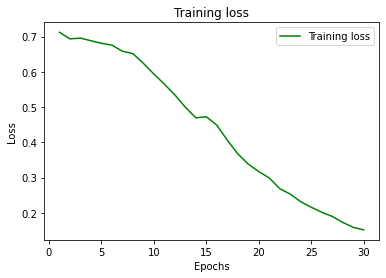

In [156]:
loss_train = history.history['loss']

epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss is decreasing which means we have some learning going on , and that is always good .

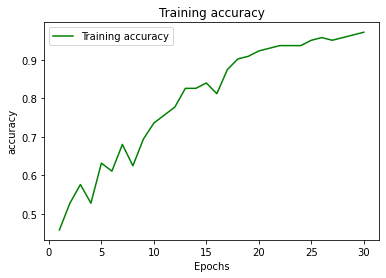

In [157]:
acc_train = history.history['accuracy']

epochs = range(1,31)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The accuracy is shooting up meaning our model is getting better and better at predicting .

# lets save the model 

In [170]:
model.save(r"C:\Users\ahmed\Desktop\trigerwords")

INFO:tensorflow:Assets written to: C:\Users\ahmed\Desktop\trigerwords\assets


# Predicting labels for the test sample

In [78]:
predictions=model.predict(x_test)
predictions

array([[0.9861172 , 0.01388277],
       [0.80976903, 0.19023097],
       [0.91537815, 0.08462187],
       [0.9554468 , 0.04455321],
       [0.35918447, 0.64081556],
       [0.9908387 , 0.00916134],
       [0.60455984, 0.3954402 ],
       [0.03142901, 0.96857095],
       [0.00327704, 0.996723  ],
       [0.991137  , 0.00886305],
       [0.99161243, 0.00838757],
       [0.376124  , 0.623876  ],
       [0.00210862, 0.99789137],
       [0.7244716 , 0.27552828],
       [0.01511059, 0.9848894 ],
       [0.7985503 , 0.20144965],
       [0.9908907 , 0.00910933],
       [0.99073154, 0.0092685 ],
       [0.65311927, 0.3468807 ],
       [0.33888078, 0.66111916],
       [0.00234017, 0.9976598 ],
       [0.00352715, 0.9964728 ],
       [0.37777373, 0.62222624],
       [0.04182799, 0.95817196],
       [0.00740918, 0.9925908 ],
       [0.1138821 , 0.88611794],
       [0.2761153 , 0.7238847 ],
       [0.00218629, 0.9978137 ],
       [0.01651609, 0.98348385],
       [0.9800238 , 0.0199762 ],
       [0.

In [79]:
pred=predictions[:,1]
pred

array([0.01388277, 0.19023097, 0.08462187, 0.04455321, 0.64081556,
       0.00916134, 0.3954402 , 0.96857095, 0.996723  , 0.00886305,
       0.00838757, 0.623876  , 0.99789137, 0.27552828, 0.9848894 ,
       0.20144965, 0.00910933, 0.0092685 , 0.3468807 , 0.66111916,
       0.9976598 , 0.9964728 , 0.62222624, 0.95817196, 0.9925908 ,
       0.88611794, 0.7238847 , 0.9978137 , 0.98348385, 0.0199762 ,
       0.9917447 , 0.99558336, 0.00911355, 0.01928735, 0.9946801 ,
       0.17982131, 0.9979517 , 0.14201856, 0.995492  , 0.9976386 ,
       0.99544466, 0.9683604 , 0.00994792, 0.02755546, 0.9925412 ,
       0.04050991, 0.19921277, 0.9979097 , 0.7061669 , 0.9899187 ,
       0.00862206, 0.96372783, 0.04155941, 0.02992079, 0.01195599,
       0.5705106 , 0.92103904, 0.99529946, 0.02125785, 0.01332673,
       0.99555945, 0.01053531, 0.9978315 , 0.00813252, 0.99786925,
       0.95774084, 0.037307  , 0.89657867, 0.00888236, 0.9979086 ,
       0.00973902, 0.99767214, 0.00919365, 0.01195195, 0.01341

In [80]:
for i in range(len(pred)):
    if pred[i]>=0.5:
        pred[i]=int(0)
    else :
        pred[i]=int(1)

In [81]:
final_pred=pred.astype(int)

In [82]:
final_pred

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

# FOR SUBMISSION ON KAGGLE 

In [ ]:
#test=pd.read_csv(r"C:\Users\ahmed\Downloads\sample_submission.csv")

In [184]:
#for index , row in test.iterrows() :
#    test["label"].loc[index]=final_pred[index]

In [182]:
#test.to_csv(r"C:\Users\ahmed\Documents\sample_submission10.csv",index=False)